# **Hybrid Rocket**

In this workbook, we introduce a hybrid training approach that can pick the most informative features from the CNN-ResBiGRU network and the Mini-Rocket transformation.

## **Initialisation**

In [1]:
pip install sktime==0.31.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 8.2 MB/s eta 0:00:00


In [28]:
import os
import numpy as np
import pickle
import itertools
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from keras.models import Model
from keras.losses import CategoricalCrossentropy
from keras.metrics import Accuracy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from keras.layers import Input, Layer, Concatenate, Lambda, Conv1D, MaxPool1D, ReLU, BatchNormalization, LayerNormalization, Dropout, Add, Dense, GlobalMaxPooling1D, Bidirectional, GRU

np.random.seed(123)

In [3]:
#You MUST run this command before reading in any data from Google Drive
from google.colab import files
from google.colab import drive
import pandas as pd
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Colab Notebooks/Thesis/experiments')

%run ../sys_configs.ipynb
%run ../plots.ipynb

Mounted at /content/drive


In [4]:
with open('../data/train.npy', 'rb') as f:
    x_train = np.load(f)
    y_train = np.load(f).astype(np.int64)
sz, dim = x_train.shape[1:]

with open('../data/val.npy', 'rb') as f:
    x_val = np.load(f)
    y_val = np.load(f).astype(np.int64)

with open('../data/test.npy', 'rb') as f:
    x_test = np.load(f)
    y_test = np.load(f).astype(np.int64)

classes = np.unique(y_train)

N_train = len(y_train)
N_val = len(y_val)
N_test = len(y_test)

In [5]:
# Convert the labels to tensors
train_labels_tf = tf.one_hot(y_train, 31, dtype=tf.float32)
val_labels_tf = tf.one_hot(y_val, 31, dtype=tf.float32)
test_labels_tf = tf.one_hot(y_test, 31, dtype=tf.float32)

In [6]:
C = len(set(y_train)) # Number of classes

#### **Prepare train & validation datasets**

We first produce the raw and first order differenced datasets.

In [7]:
# Convert the raw dataset to tensors
train_raw_tf = tf.convert_to_tensor(x_train[:, :-1, :], dtype=tf.float32)
val_raw_tf = tf.convert_to_tensor(x_val[:, :-1, :], dtype=tf.float32)
test_raw_tf = tf.convert_to_tensor(x_test[:, :-1, :], dtype=tf.float32)

#### **Prepare Rocket transformation train & validation datasets**

We use the *sktime* MiniRocket implementation, which is the same implementation introduced in the MiniRocket paper.

In [8]:
# Transpose the train and validation data as the format needs to be N x D x (T - 1)
x_train_ = x_train[:, :-1, :].transpose((0, 2, 1))
x_val_ = x_val[:, :-1, :].transpose((0, 2, 1))
x_test_ = x_test[:, :-1, :].transpose((0, 2, 1))

In [9]:
# Compute the MiniRocket transform and transform to tensors
minirocket_multi = MiniRocketMultivariate(num_kernels = 10000, max_dilations_per_kernel = 32)
minirocket_multi.fit(x_train_)

train_rocket_np = minirocket_multi.transform(x_train_)
val_rocket_np = minirocket_multi.transform(x_val_)
test_rocket_np = minirocket_multi.transform(x_test_)

train_rocket_tf = tf.convert_to_tensor(train_rocket_np, dtype = tf.float32)
val_rocket_tf = tf.convert_to_tensor(val_rocket_np, dtype = tf.float32)
test_rocket_tf = tf.convert_to_tensor(test_rocket_np, dtype = tf.float32)

#### **Prepare PCA transformation train & validation datasets**

In [10]:
pca_rocket = PCA(n_components=128)
pca_rocket.fit(train_rocket_np)

PCA(n_components=128)

In [11]:
train_pca_np = pca_rocket.transform(train_rocket_np)
val_pca_np = pca_rocket.transform(val_rocket_np)
test_pca_np = pca_rocket.transform(test_rocket_np)

In [12]:
train_pca_tf = tf.convert_to_tensor(train_pca_np, dtype = tf.float32)
val_pca_tf = tf.convert_to_tensor(val_pca_np, dtype = tf.float32)
test_pca_tf = tf.convert_to_tensor(test_pca_np, dtype = tf.float32)

#### **Combine input datasets**

We now prepare different Tensorflow datasets for the experiments in this workbook.

**Dataset 1: Raw + Rocket Transformation Time Series**

In [13]:
train_rr_ds = tf.data.Dataset.from_tensor_slices((train_raw_tf, train_rocket_tf, train_labels_tf))
val_rr_ds = tf.data.Dataset.from_tensor_slices((val_raw_tf, val_rocket_tf, val_labels_tf))
test_rr_ds = tf.data.Dataset.from_tensor_slices((test_raw_tf, test_rocket_tf, test_labels_tf))

# Map function to process the dataset elements
def map_rr(raw, rocket, label):
    return {"raw": raw, "rocket": rocket}, label

# Apply the mapping function
train_rr_ds = train_rr_ds.map(map_rr)
val_rr_ds = val_rr_ds.map(map_rr)
test_rr_ds = test_rr_ds.map(map_rr)

train_rr_ds = train_rr_ds.shuffle(500)

train_rr_ds = train_rr_ds.padded_batch(64)
val_rr_ds = val_rr_ds.padded_batch(64)
test_rr_ds = test_rr_ds.padded_batch(64)

**Dataset 2: Raw + Rocket PCA Transformation Time Series**

In [14]:
train_rp_ds = tf.data.Dataset.from_tensor_slices((train_raw_tf, train_pca_tf, train_labels_tf))
val_rp_ds = tf.data.Dataset.from_tensor_slices((val_raw_tf, val_pca_tf, val_labels_tf))
test_rp_ds = tf.data.Dataset.from_tensor_slices((test_raw_tf, test_pca_tf, test_labels_tf))

# Map function to process the dataset elements
def map_rp(raw, pca, label):
    return {"raw": raw, "pca": pca}, label

# Apply the mapping function
train_rp_ds = train_rp_ds.map(map_rp)
val_rp_ds = val_rp_ds.map(map_rp)
test_rp_ds = test_rp_ds.map(map_rp)

train_rp_ds = train_rp_ds.shuffle(500)

train_rp_ds = train_rp_ds.padded_batch(64)
val_rp_ds = val_rp_ds.padded_batch(64)
test_rp_ds = test_rp_ds.padded_batch(64)

## **Set up standard CNN-ResBiGRU blocks**

In [15]:
class ConvBlock(Layer):

    def __init__(self, num_filters, **kwargs):
        super().__init__(**kwargs)
        self.num_filters = num_filters

    def build(self, input_shape): # Tensorflow calls this method automatically when the object is defined
        self.conv = Conv1D(self.num_filters, kernel_size=10, strides = 1, padding="same")
        self.batch_norm = BatchNormalization()
        self.max_pool = MaxPool1D(pool_size=3, strides=1, padding="same")
        self.dropout = Dropout(0.25)

    def call(self, input):
        x = self.conv(input)
        x = self.batch_norm(x)
        x = self.max_pool(x)
        output = self.dropout(x)
        return output

In [16]:
class ResBiGRU(Layer):

    def __init__(self, h1_units, h2_units, **kwargs):
        super().__init__(**kwargs)
        self.h1_units = h1_units
        self.h2_units = h2_units

    def build(self, input_shape): # Tensorflow calls this method automatically when the object is defined
        self.gru_1 =  Bidirectional(GRU(self.h1_units, activation = None, return_sequences=True), merge_mode=None)
        self.gru_2a = GRU(self.h2_units, activation = None, return_sequences=True)
        self.gru_2b = GRU(self.h2_units, activation = None, return_sequences=True)
        self.layer_norm = LayerNormalization()

    def call(self, input):
        # In the first (hidden) RNN layer, apply the forward and backward GRU layers concurrently
        z_forward, z_backward = self.gru_1(input)

        # In the second (hidden) RNN layer, apply the forward and backward GRU layers separately
        z2_forward = self.gru_2a(z_forward)
        z2_backward = self.gru_2b(z_backward)

        # Add the output of the first RNN layer to the output of the second RNN layer
        z_forward = Add()([z_forward, z2_forward])
        z_backward = Add()([z_backward, z2_backward])

        z_forward = self.layer_norm(z_forward)
        z_backward = self.layer_norm(z_backward)

        output = tf.concat([z_forward, z_backward], axis = 2)
        return output

In [17]:
# We use early stopping as CNNResBiGRU is a high parameter network, so requires many epochs to train.
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10)

# The previous benchmark paper also made use of ReduceLROnPlateau which reduces the lesrning rate when the loss plateaus.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=10e-5)

## **Method 1: Train all weights at once (PCA)**

In this experiment, we apply batch normalisation to both the component acting on the raw time series and the component acting on the Rocket.

In a since discarded experiment, we consider concatenating the two components and adding an additional fully connected layer on the combined fields.

In the experiment shown below, we follow up on the Rocket batch normalisation with a fully connected layer of 64 dimensions, in order to condense the 9,996 Rocket features into a more compact representation. This replaced the additional fully connected layer on the combined fields.

In [22]:
def RocketCNNResBiGRU(ts_raw_shape, pca_raw_shape):
    ts_raw_input = Input(shape=ts_raw_shape, name = "raw")
    pca_raw_input = Input(shape=pca_raw_shape, name = "pca")

    ts_layer = ConvBlock(num_filters = 32, name = "ConvBlock")(ts_raw_input)
    ts_layer = ConvBlock(num_filters = 32, name = "ConvBlock2")(ts_layer)
    ts_layer = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU1")(ts_layer)
    ts_layer = GlobalMaxPooling1D()(ts_layer)

    pca_layer = BatchNormalization()(pca_raw_input)
    pca_layer = Dense(64, activation="sigmoid")(pca_layer) # Compress the information into 32 dimensions

    combined_layer = Concatenate(axis = 1)([pca_layer, ts_layer])

    output_layer = Dense(C, activation="softmax")(combined_layer)
    return Model(inputs=[pca_raw_input, ts_raw_input], outputs=output_layer)

In [23]:
RocketCNNResBiGRU_model = RocketCNNResBiGRU(ts_raw_shape = (sz - 1, dim), pca_raw_shape = (128,))
RocketCNNResBiGRU_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ raw (InputLayer)          │ (None, 149, 6)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ConvBlock (ConvBlock)     │ (None, 149, 32)        │          2,080 │ raw[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pca (InputLayer)          │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ConvBlock2 (ConvBlock)    │ (None, 149, 32)        │         10,400 │ ConvBlock[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 128)            │            512 │ pca[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ResBiGRU1 (ResBiGRU)      │ (None, 149, 64)        │         25,408 │ ConvBlock2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 64)             │              0 │ ResBiGRU1[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128)            │              0 │ dense_2[0][0],         │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 31)             │          3,999 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 50,655 (197.87 KB)

 Trainable params: 50,271 (196.37 KB)

 Non-trainable params: 384 (1.50 KB)

In [25]:
RocketCNNResBiGRU_model = RocketCNNResBiGRU(ts_raw_shape = (sz - 1, dim), pca_raw_shape = (128,))
RocketCNNResBiGRU_model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])
historyR1 = RocketCNNResBiGRU_model.fit(train_rp_ds, validation_data=val_rp_ds, epochs=50, verbose = 1, callbacks = [reduce_lr, earlystopping])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 232ms/step - accuracy: 0.1948 - loss: 3.0960 - val_accuracy: 0.5065 - val_loss: 1.7785 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.5995 - loss: 1.5464 - val_accuracy: 0.6128 - val_loss: 1.2191 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.7361 - loss: 1.0623 - val_accuracy: 0.7105 - val_loss: 0.9456 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.8215 - loss: 0.7738 - val_accuracy: 0.7249 - val_loss: 0.7976 - learning_rate: 0.0010
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.8719 - loss: 0.5814 - val_accuracy: 0.7486 - val_loss: 0.7257 - learning_rate: 0.0010
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9013 - loss: 0.4492 - val_accuracy: 0.7565 - val_loss: 0.6725 - learning_rate: 0.0010
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9367 - loss: 0.3391 -

In [29]:
RocketCNNResBiGRU_results_val = RocketCNNResBiGRU_model.evaluate(val_rp_ds, batch_size=128)
RocketCNNResBiGRU_results_test = RocketCNNResBiGRU_model.evaluate(test_rp_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}".format(*RocketCNNResBiGRU_results_val))
print("Test Loss: {}\nTest Accuracy: {}".format(*RocketCNNResBiGRU_results_test))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7394 - loss: 0.6939
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7398 - loss: 0.7201
Validation Loss: 0.6291372776031494
Validation Accuracy: 0.756465494632721
Test Loss: 0.6906863451004028
Test Accuracy: 0.7526165843009949


In [27]:
predictions_combined_val = RocketCNNResBiGRU_model.predict((val_pca_tf, val_raw_tf), batch_size=128)
predictions_combined_test = RocketCNNResBiGRU_model.predict((test_pca_tf, test_raw_tf), batch_size=128)

predictions_combined_val =tf.argmax(predictions_combined_val, axis = 1)
predictions_combined_test = tf.argmax(predictions_combined_test, axis = 1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


In [34]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_val), sum(np.equal(predictions_combined_val, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_test), sum(np.equal(predictions_combined_test, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 1053
Test Data - Total predictions made: 1051. Number of correct predictions: 791


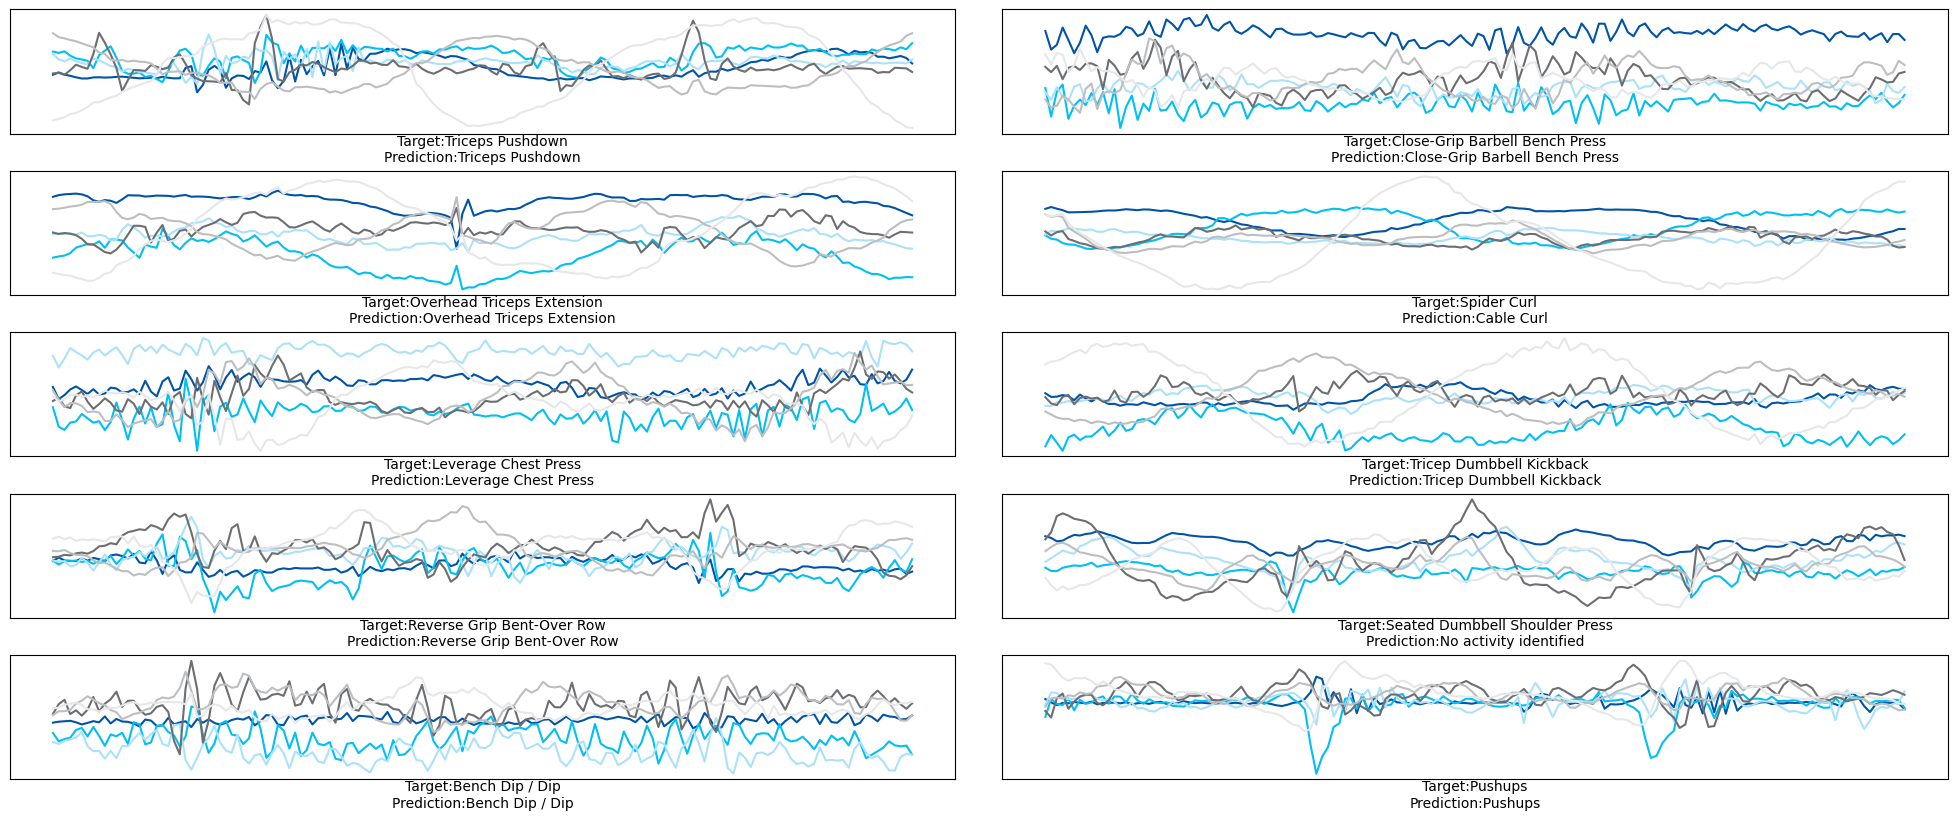

In [35]:
plot_samples(data = x_test, labels = y_test, predictions = predictions_combined_test.numpy())

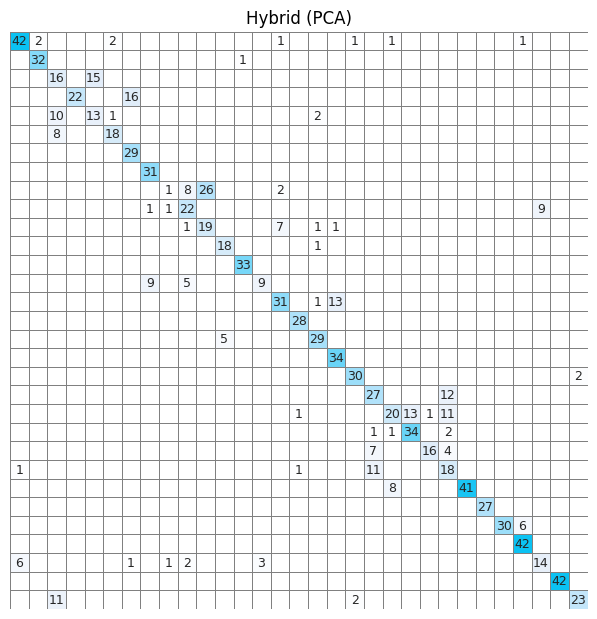

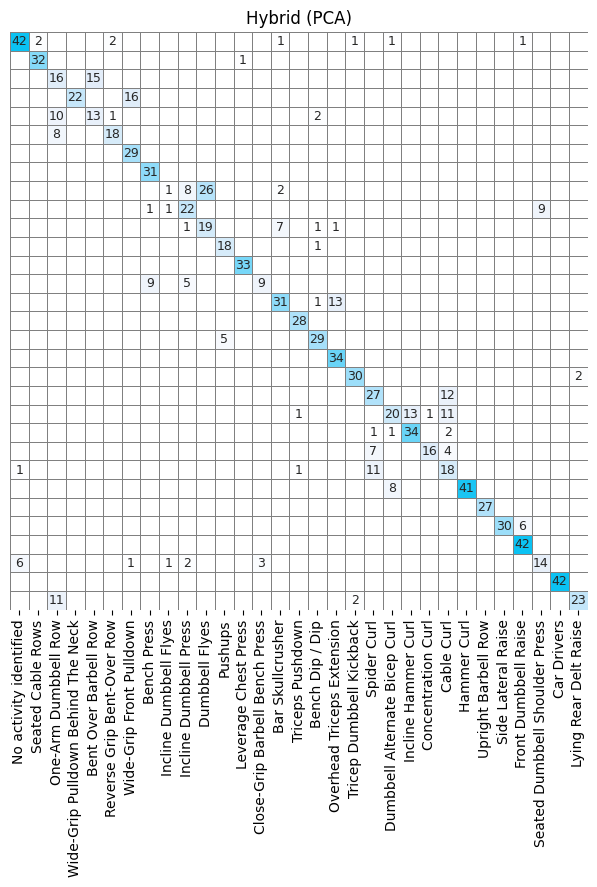

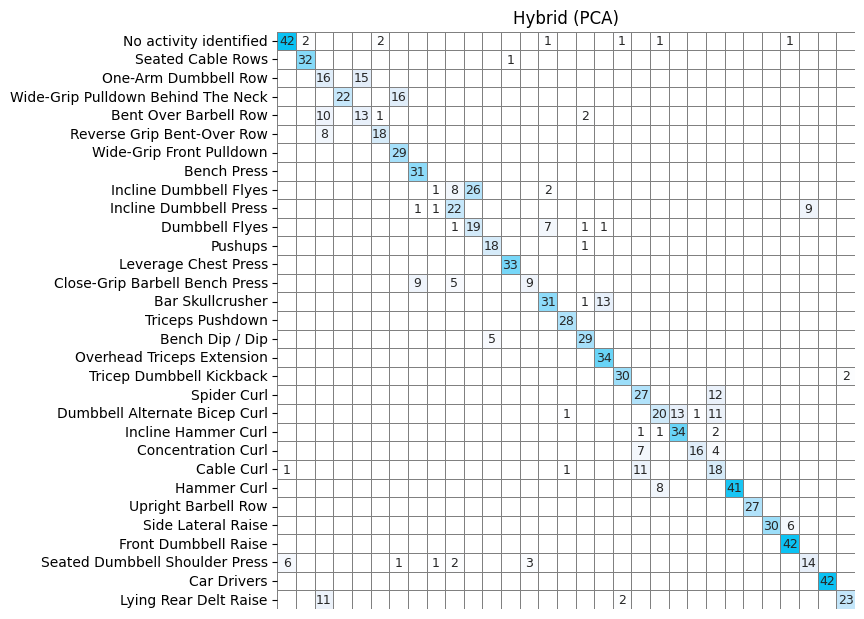

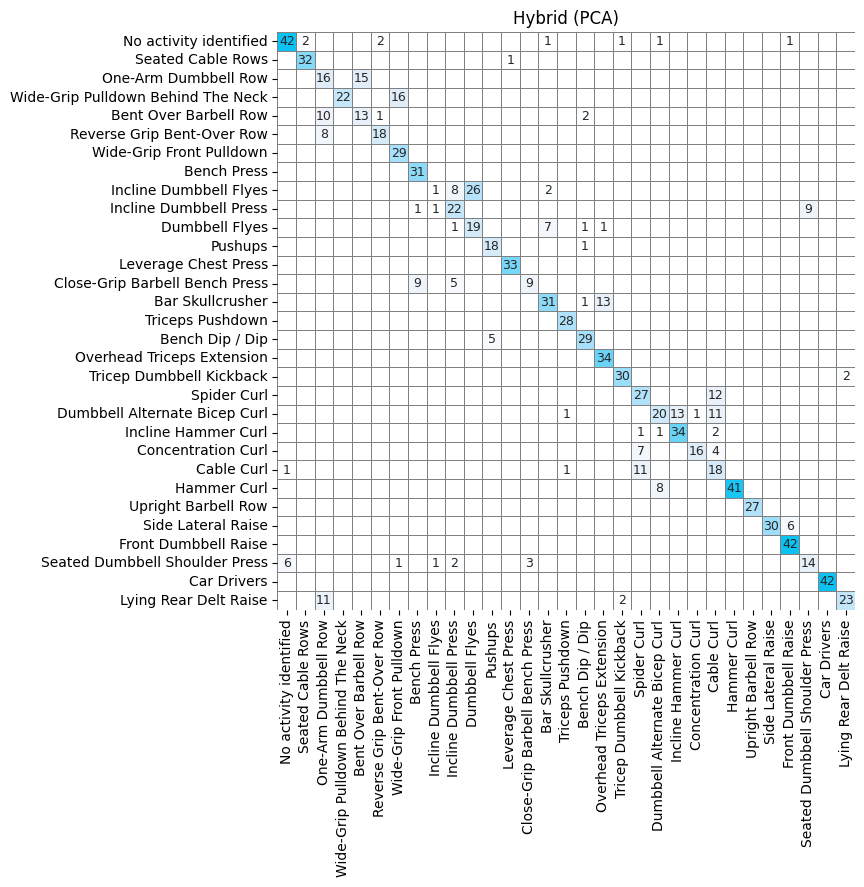

In [36]:
cm1 = confusion_matrix(y_test, predictions_combined_test, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm1, x_ticks = False, y_ticks = False, save = True, title = "Hybrid (PCA)")
plot_confusion_matrix(cm1, x_ticks = True, y_ticks = False, save = True, title = "Hybrid (PCA)")
plot_confusion_matrix(cm1, x_ticks = False, y_ticks = True, save = True, title = "Hybrid (PCA)")
plot_confusion_matrix(cm1, x_ticks = True, y_ticks = True, save = True, title = "Hybrid (PCA)")

## **Method 2: Train all weights at once (Rocket)**

In [33]:
def RocketCNNResBiGRU2(ts_raw_shape, rocket_raw_shape):
    ts_raw_input = Input(shape=ts_raw_shape, name = "raw")
    rocket_raw_input = Input(shape=rocket_raw_shape, name = "rocket")

    ts_layer = ConvBlock(num_filters = 32, name = "ConvBlock")(ts_raw_input)
    ts_layer = ConvBlock(num_filters = 32, name = "ConvBlock2")(ts_layer)
    ts_layer = ResBiGRU(h1_units = 32, h2_units = 32, name = "ResBiGRU1")(ts_layer)
    ts_layer = GlobalMaxPooling1D()(ts_layer)

    rocket_layer = BatchNormalization()(rocket_raw_input)
    rocket_layer = Dense(64, activation="sigmoid")(rocket_layer) # Compress the information into 32 dimensions

    combined_layer = Concatenate(axis = 1)([rocket_layer, ts_layer])

    output_layer = Dense(C, activation="softmax")(combined_layer)
    return Model(inputs={"raw": ts_raw_input, "rocket": rocket_raw_input}, outputs=output_layer)

In [37]:
RocketCNNResBiGRU_model2 = RocketCNNResBiGRU2(ts_raw_shape = (sz - 1, dim), rocket_raw_shape = (9996,))
RocketCNNResBiGRU_model2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ raw (InputLayer)          │ (None, 149, 6)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ConvBlock (ConvBlock)     │ (None, 149, 32)        │          2,080 │ raw[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rocket (InputLayer)       │ (None, 9996)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ConvBlock2 (ConvBlock)    │ (None, 149, 32)        │         10,400 │ ConvBlock[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 9996)           │         39,984 │ rocket[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ResBiGRU1 (ResBiGRU)      │ (None, 149, 64)        │         25,408 │ ConvBlock2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │        639,808 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 64)             │              0 │ ResBiGRU1[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 128)            │              0 │ dense_8[0][0],         │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 31)             │          3,999 │ concatenate_4[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 721,679 (2.75 MB)

 Trainable params: 701,559 (2.68 MB)

 Non-trainable params: 20,120 (78.59 KB)

In [38]:
RocketCNNResBiGRU_model2 = RocketCNNResBiGRU2(ts_raw_shape = (sz - 1, dim), rocket_raw_shape = (9996,))
RocketCNNResBiGRU_model2.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.90, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])
historyR2 = RocketCNNResBiGRU_model2.fit(train_rr_ds, validation_data=val_rr_ds, epochs=50, verbose = 1, callbacks = [reduce_lr, earlystopping])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - accuracy: 0.3665 - loss: 2.6795 - val_accuracy: 0.4878 - val_loss: 1.7898 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.8584 - loss: 0.8404 - val_accuracy: 0.6401 - val_loss: 1.2347 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.9479 - loss: 0.4689 - val_accuracy: 0.7371 - val_loss: 0.8848 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9774 - loss: 0.2817 - val_accuracy: 0.7644 - val_loss: 0.7485 - learning_rate: 0.0010
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.9888 - loss: 0.1857 - val_accuracy: 0.7881 - val_loss: 0.6263 - learning_rate: 0.0010
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9961 - loss: 0.1157 - val_accuracy: 0.7924 - val_loss: 0.5755 - learning_rate: 0.0010
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.9978 - loss: 0.0857 -

In [39]:
RocketCNNResBiGRU_results2_val = RocketCNNResBiGRU_model2.evaluate(val_rr_ds, batch_size=128)
RocketCNNResBiGRU_results2_test = RocketCNNResBiGRU_model2.evaluate(test_rr_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}".format(*RocketCNNResBiGRU_results2_val))
print("Test Loss: {}\nTest Accuracy: {}".format(*RocketCNNResBiGRU_results2_test))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8143 - loss: 0.5257
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7829 - loss: 0.6898
Validation Loss: 0.48000121116638184
Validation Accuracy: 0.818965494632721
Test Loss: 0.663541853427887
Test Accuracy: 0.7897240519523621


In [40]:
predictions_combined_val2 = RocketCNNResBiGRU_model2.predict((val_raw_tf, val_rocket_tf), batch_size=128)
predictions_combined_test2 = RocketCNNResBiGRU_model2.predict((test_raw_tf,test_rocket_tf), batch_size=128)

predictions_combined_val2 =tf.argmax(predictions_combined_val2, axis = 1)
predictions_combined_test2 = tf.argmax(predictions_combined_test2, axis = 1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


In [41]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_val2), sum(np.equal(predictions_combined_val2, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_test2), sum(np.equal(predictions_combined_test2, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 1140
Test Data - Total predictions made: 1051. Number of correct predictions: 830


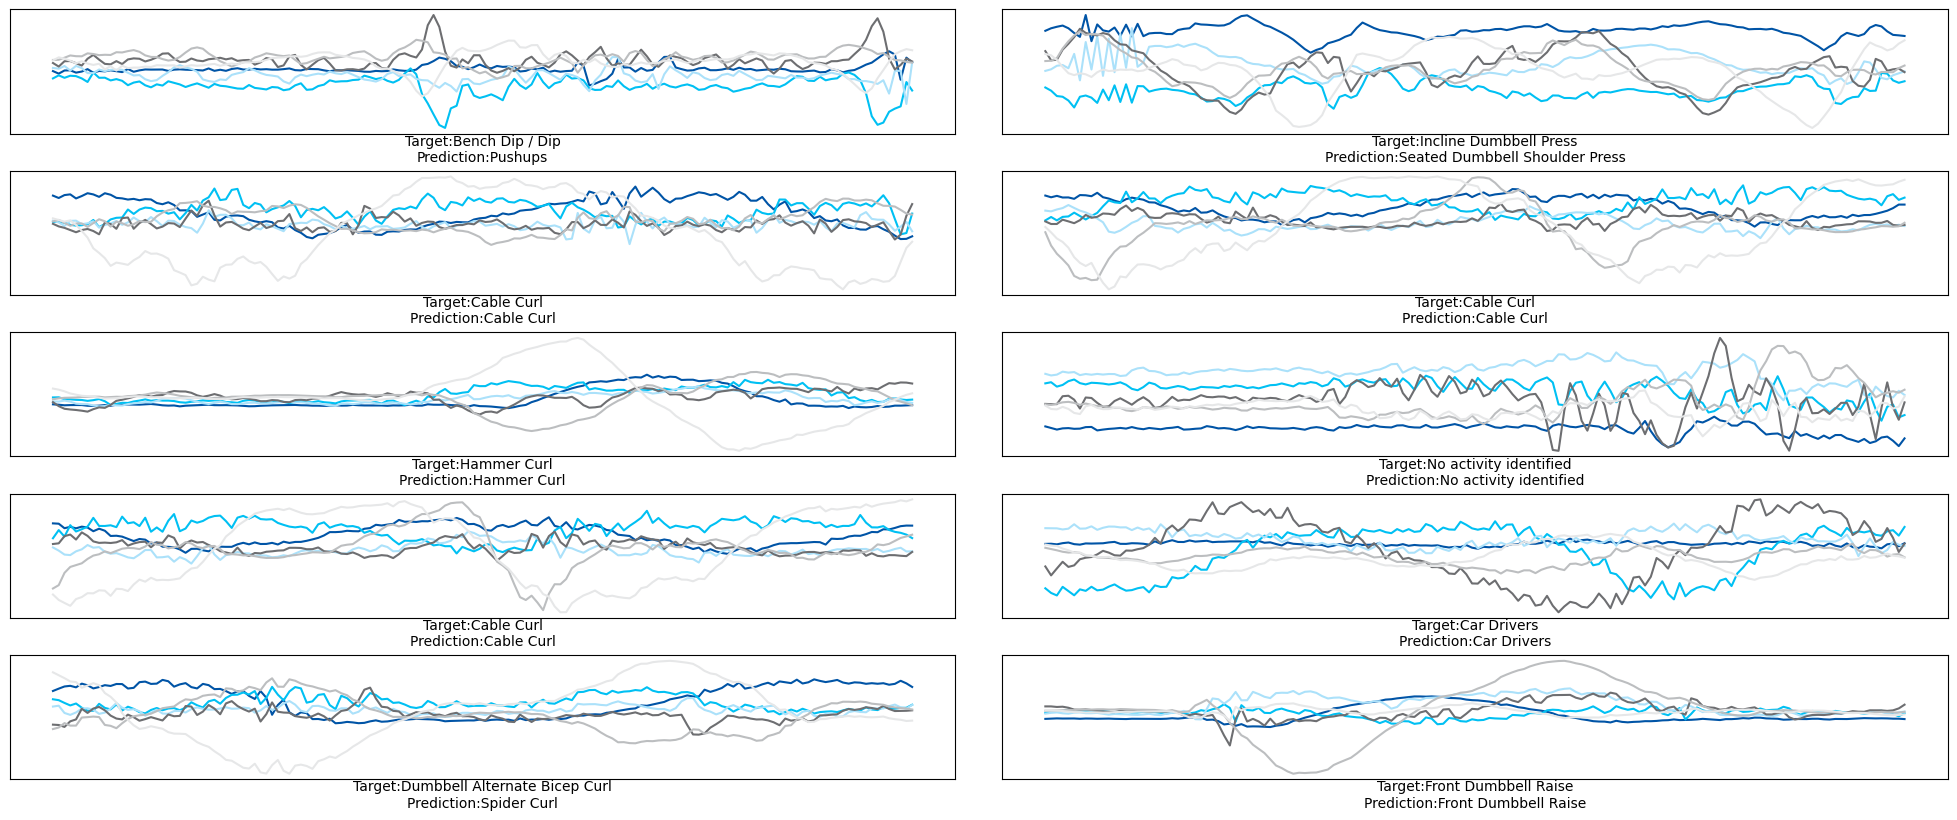

In [42]:
plot_samples(data = x_test, labels = y_test, predictions = predictions_combined_test2.numpy())

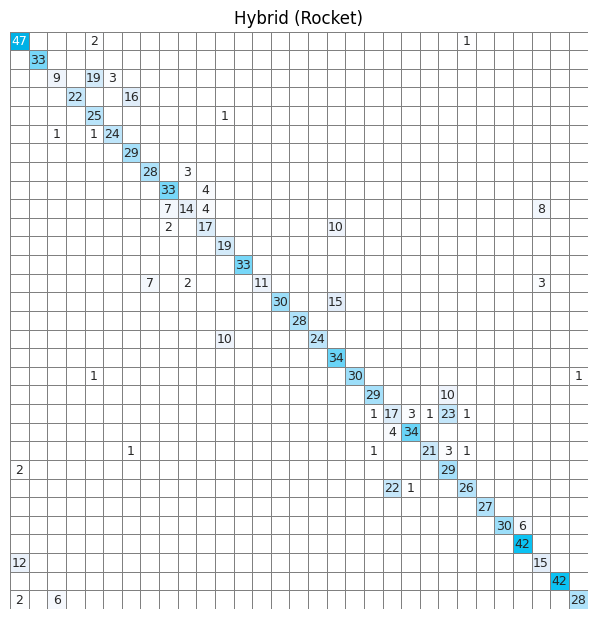

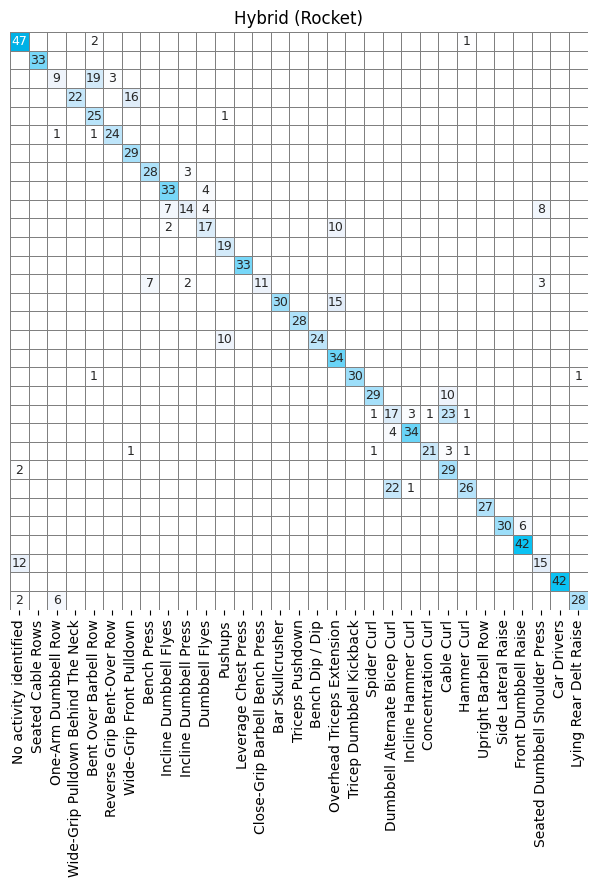

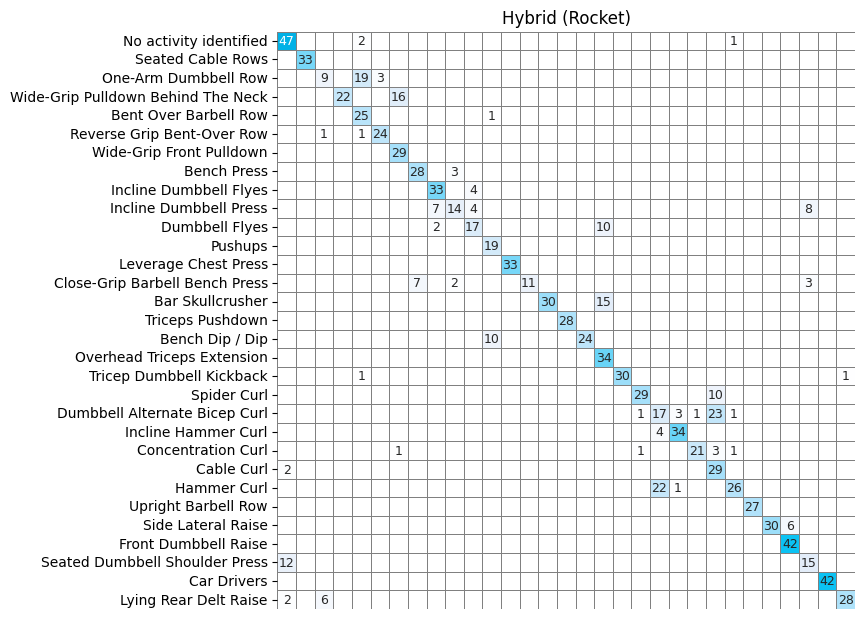

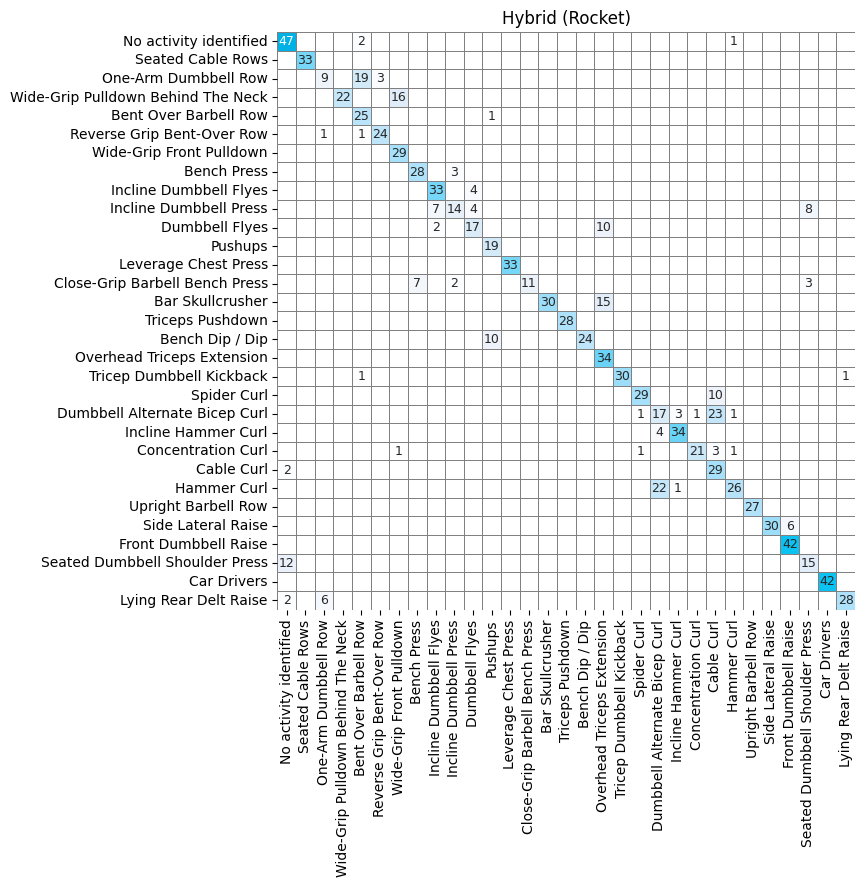

In [44]:
cm2 = confusion_matrix(y_test, predictions_combined_test2, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm2, x_ticks = False, y_ticks = False, save = True, title = "Hybrid (Rocket)")
plot_confusion_matrix(cm2, x_ticks = True, y_ticks = False, save = True, title = "Hybrid (Rocket)")
plot_confusion_matrix(cm2, x_ticks = False, y_ticks = True, save = True, title = "Hybrid (Rocket)")
plot_confusion_matrix(cm2, x_ticks = True, y_ticks = True, save = True, title = "Hybrid (Rocket)")

## **Method 3: 2 component training process (Rocket)**

In [50]:
ts_raw_input = Input(shape=(sz - 1, dim), name = "raw")
rocket_raw_input = Input(shape=(9996,), name = "rocket")

# Define the layers of the time series model
ts_layer = ConvBlock(num_filters = 32, name = "ts_ConvBlock1")(ts_raw_input)
ts_layer = ConvBlock(num_filters = 32, name = "ts_ConvBlock2")(ts_layer)
ts_layer = ResBiGRU(h1_units = 32, h2_units = 32, name = "ts_ResBiGRU1")(ts_layer)
ts_layer = GlobalMaxPooling1D(name = "ts_GlobalMaxPooling")(ts_layer)
ts_layer = BatchNormalization(momentum=0.99, center=True, scale=True, name = "ts_BatchNorm")(ts_layer)
output_ts = ts_layer

# Define the layers of the PCA model based on the Rocket features
rocket_layer = BatchNormalization(name = "rocket_BatchNorm")(rocket_raw_input)
rocket_layer = Dense(64, activation="sigmoid", name = "rocket_Dense")(rocket_layer)
output_rocket = rocket_layer

# Define the two component models
ts_model = Model(inputs=ts_raw_input, outputs=output_ts)
rocket_model = Model(inputs=rocket_raw_input, outputs=output_rocket)

# Define the layers of the combined model
combined_layer = Concatenate(axis = 1)([ts_model.output, rocket_model.output])
combined_layer = Dense(32, activation="sigmoid", name = "comb_Dense1")(combined_layer) # Compress the information into 32 dimensions
final_output  = Dense(C, activation="softmax", name = "comb_Dense2")(combined_layer)

# Define the combined model
RocketCNNResBiGRU3 = Model(inputs= {"raw": ts_model.input, "rocket": rocket_model.input}, outputs = final_output)
RocketCNNResBiGRU3.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ raw (InputLayer)          │ (None, 149, 6)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_ConvBlock1 (ConvBlock) │ (None, 149, 32)        │          2,080 │ raw[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_ConvBlock2 (ConvBlock) │ (None, 149, 32)        │         10,400 │ ts_ConvBlock1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_ResBiGRU1 (ResBiGRU)   │ (None, 149, 64)        │         25,408 │ ts_ConvBlock2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rocket (InputLayer)       │ (None, 9996)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_GlobalMaxPooling       │ (None, 64)             │              0 │ ts_ResBiGRU1[0][0]     │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rocket_BatchNorm          │ (None, 9996)           │         39,984 │ rocket[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_BatchNorm              │ (None, 64)             │            256 │ ts_GlobalMaxPooling[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rocket_Dense (Dense)      │ (None, 64)             │        639,808 │ rocket_BatchNorm[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 128)            │              0 │ ts_BatchNorm[0][0],    │
│ (Concatenate)             │                        │                │ rocket_Dense[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ comb_Dense1 (Dense)       │ (None, 32)             │          4,128 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ comb_Dense2 (Dense)       │ (None, 31)             │          1,023 │ comb_Dense1[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 723,087 (2.76 MB)

 Trainable params: 702,839 (2.68 MB)

 Non-trainable params: 20,248 (79.09 KB)

In [51]:
rocket_layers = [layer.name for layer in rocket_model.layers]
ts_layers = [layer.name for layer in ts_model.layers]
combined_layers = [layer.name for layer in RocketCNNResBiGRU3.layers]

# The layers which are shared between both components of the model.
shared_layers = list(set(combined_layers) - set(rocket_layers) - set(ts_layers))

rocket_component_layers = rocket_layers + shared_layers
ts_component_layers = ts_layers + shared_layers

In [54]:
RocketCNNResBiGRU3_model = Model(inputs= {"raw": ts_model.input, "rocket": rocket_model.input}, outputs = RocketCNNResBiGRU3.output)
RocketCNNResBiGRU3_model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
# Custom training loop
epochs = 10 # 5 sub-epochs per parent epoch = 50 epochs

# Keras optimisers are tied to the weights they are created with
ts_optimiser = Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08)
rocket_optimiser = Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    # Freeze the Rocket component and train the CNN-ResBiGRU component
    for layer in RocketCNNResBiGRU3_model.layers:  # Adjust indices based on your model's architecture
        if layer.name in ts_component_layers:
            layer.trainable = True
        else:
            layer.trainable = False

    RocketCNNResBiGRU3.compile(optimizer= ts_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
    RocketCNNResBiGRU3_model.fit(train_rr_ds, validation_data = val_rr_ds, epochs=5, verbose=1, callbacks = [reduce_lr, earlystopping])

    # Freeze the CNN-ResBiGRU component and train the Rocket component
    for layer in RocketCNNResBiGRU3_model.layers:  # Adjust indices based on your model's architecture
        if layer.name in rocket_component_layers:
            layer.trainable = True
        else:
            layer.trainable = False

    RocketCNNResBiGRU3_model.compile(optimizer= rocket_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
    RocketCNNResBiGRU3_model.fit(train_rr_ds, validation_data = val_rr_ds, epochs=5, verbose=1, callbacks = [reduce_lr, earlystopping])

Epoch 1/10
Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 266ms/step - accuracy: 0.1517 - loss: 3.1726 - val_accuracy: 0.2335 - val_loss: 2.8039 - learning_rate: 0.0010
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.3374 - loss: 2.6129 - val_accuracy: 0.3843 - val_loss: 2.3364 - learning_rate: 0.0010
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.4536 - loss: 2.2536 - val_accuracy: 0.4619 - val_loss: 2.0078 - learning_rate: 0.0010
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.5374 - loss: 1.9464 - val_accuracy: 0.5603 - val_loss: 1.7611 - learning_rate: 0.0010
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.6147 - loss: 1.6750 - val_accuracy: 0.6193 - val_loss: 1.5631 - learning_rate: 0.0010
Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.7029 - loss: 1.4036 - val_accuracy: 0.6343 - val_loss: 1.4184 - learning_rate: 0.0010
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7754 - loss: 1.17

In [56]:
RocketCNNResBiGRU_results3_val = RocketCNNResBiGRU3_model.evaluate(val_rr_ds, batch_size=128)
RocketCNNResBiGRU_results3_test = RocketCNNResBiGRU3_model.evaluate(test_rr_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}".format(*RocketCNNResBiGRU_results3_val))
print("Test Loss: {}\nTest Accuracy: {}".format(*RocketCNNResBiGRU_results3_test))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7688 - loss: 0.7551
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7426 - loss: 0.8280
Validation Loss: 0.7109200358390808
Validation Accuracy: 0.7801724076271057
Test Loss: 0.8398138284683228
Test Accuracy: 0.7431018352508545


In [59]:
predictions_combined_val3 = RocketCNNResBiGRU3_model.predict((val_raw_tf, val_rocket_tf), batch_size=128)
predictions_combined_test3 = RocketCNNResBiGRU3_model.predict((test_raw_tf, test_rocket_tf), batch_size=128)

predictions_combined_val3 = tf.argmax(predictions_combined_val3, axis = 1)
predictions_combined_test3 = tf.argmax(predictions_combined_test3, axis = 1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [60]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_val3), sum(np.equal(predictions_combined_val3, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_test3), sum(np.equal(predictions_combined_test3, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 1086
Test Data - Total predictions made: 1051. Number of correct predictions: 781


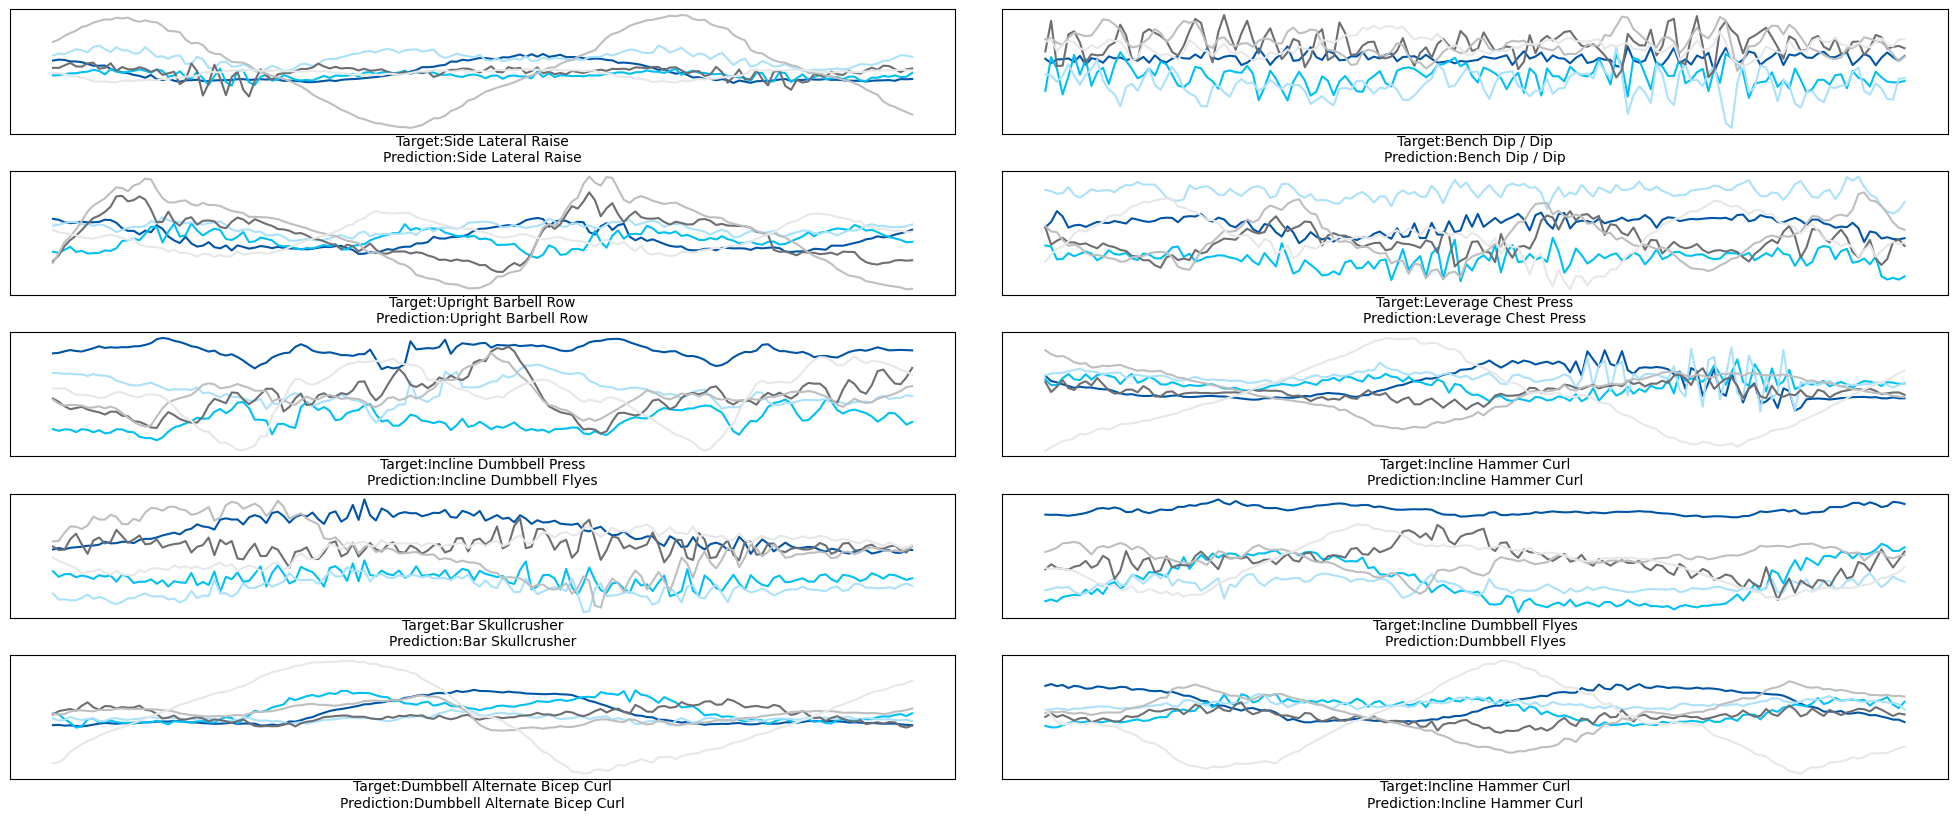

In [61]:
plot_samples(data = x_test, labels = y_test, predictions = predictions_combined_test3.numpy())

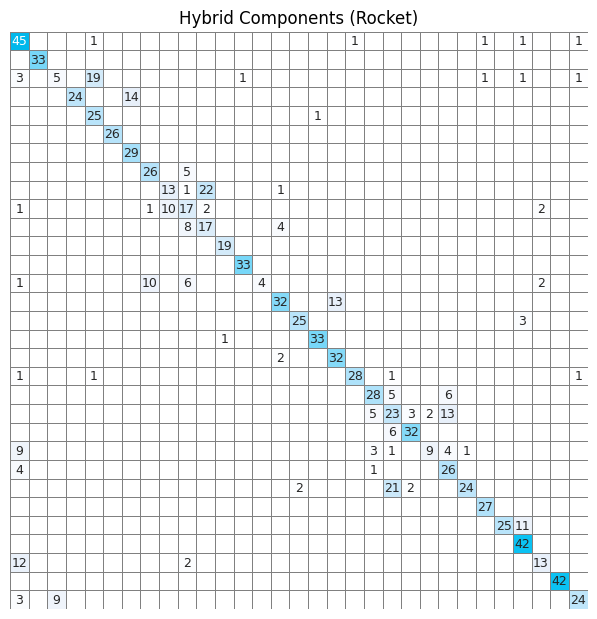

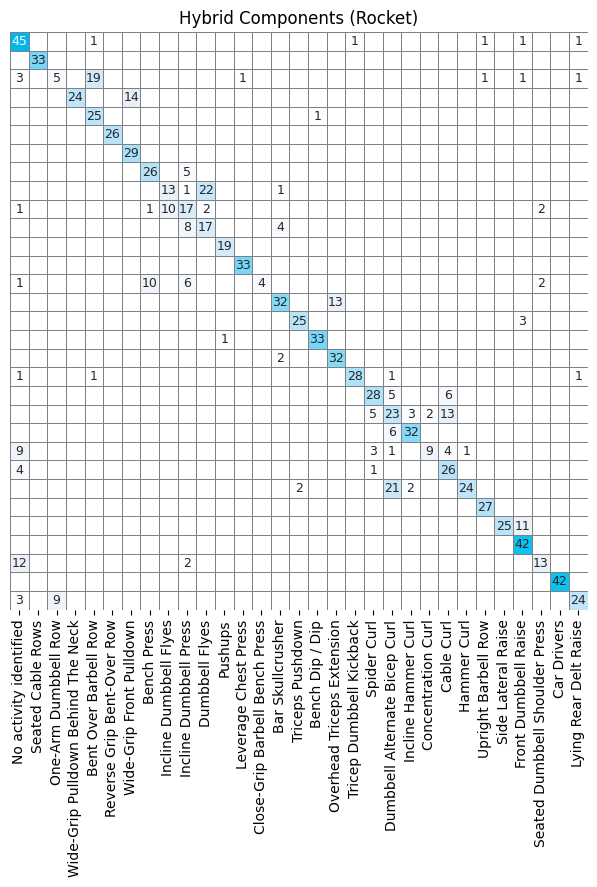

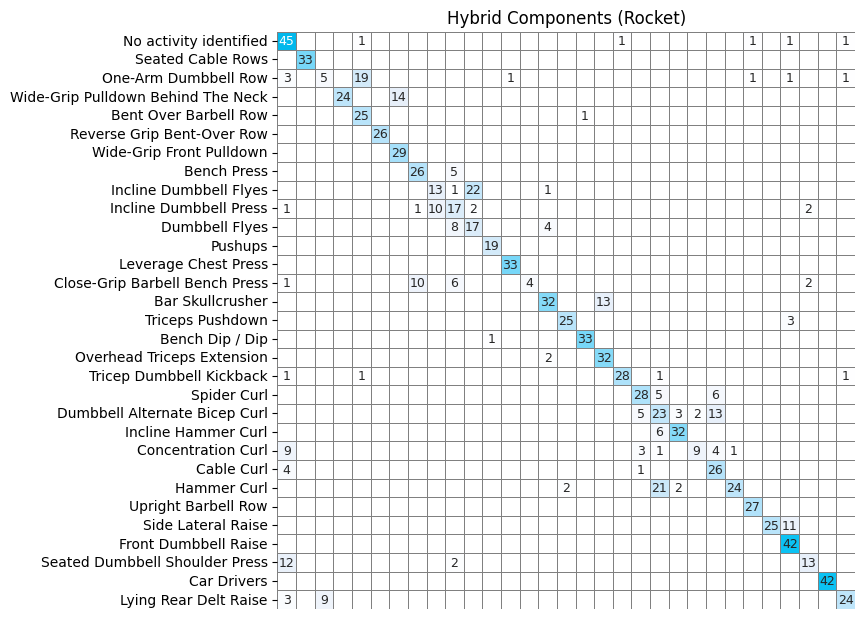

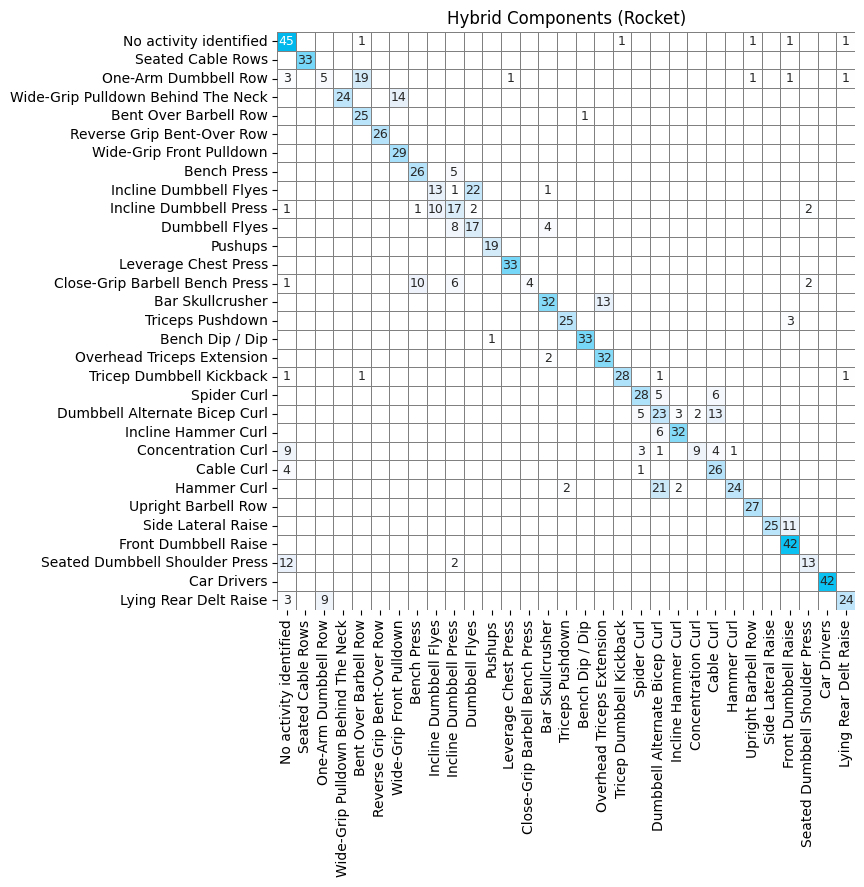

In [62]:
cm3 = confusion_matrix(y_test, predictions_combined_test3, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm3, x_ticks = False, y_ticks = False, save = True, title = "Hybrid Components (Rocket)")
plot_confusion_matrix(cm3, x_ticks = True, y_ticks = False, save = True, title = "Hybrid Components (Rocket)")
plot_confusion_matrix(cm3, x_ticks = False, y_ticks = True, save = True, title = "Hybrid Components (Rocket)")
plot_confusion_matrix(cm3, x_ticks = True, y_ticks = True, save = True, title = "Hybrid Components (Rocket)")

## **Method 4: 2 component training process (PCA)**

In [64]:
ts_raw_input = Input(shape=(sz - 1, dim), name = "raw")
pca_raw_input = Input(shape=(128,), name = "pca")

# Define the layers of the time series model
ts_layer = ConvBlock(num_filters = 32, name = "ts_ConvBlock1")(ts_raw_input)
ts_layer = ConvBlock(num_filters = 32, name = "ts_ConvBlock2")(ts_layer)
ts_layer = ResBiGRU(h1_units = 32, h2_units = 32, name = "ts_ResBiGRU1")(ts_layer)
ts_layer = GlobalMaxPooling1D(name = "ts_GlobalMaxPooling")(ts_layer)
ts_layer = BatchNormalization(momentum=0.99, center=True, scale=True, name = "ts_BatchNorm")(ts_layer)
output_ts = ts_layer

# Define the layers of the PCA model based on the Rocket features
pca_layer = BatchNormalization(name = "pca_BatchNorm")(pca_raw_input)
pca_layer = Dense(64, activation="sigmoid", name = "pca_Dense")(pca_layer)
output_pca = pca_layer

# Define the two component models
ts_model = Model(inputs=ts_raw_input, outputs=output_ts)
pca_model = Model(inputs=pca_raw_input, outputs=output_pca)

# Define the layers of the combined model
combined_layer = Concatenate(axis = 1)([ts_model.output, pca_model.output])
combined_layer = Dense(32, activation="sigmoid", name = "comb_Dense1")(combined_layer) # Compress the information into 32 dimensions
final_output  = Dense(C, activation="softmax", name = "comb_Dense2")(combined_layer)

# Define the combined model
RocketCNNResBiGRU4 = Model(inputs= {"raw": ts_model.input, "pca": pca_model.input}, outputs = final_output)
RocketCNNResBiGRU4.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ raw (InputLayer)          │ (None, 149, 6)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_ConvBlock1 (ConvBlock) │ (None, 149, 32)        │          2,080 │ raw[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_ConvBlock2 (ConvBlock) │ (None, 149, 32)        │         10,400 │ ts_ConvBlock1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_ResBiGRU1 (ResBiGRU)   │ (None, 149, 64)        │         25,408 │ ts_ConvBlock2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pca (InputLayer)          │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_GlobalMaxPooling       │ (None, 64)             │              0 │ ts_ResBiGRU1[0][0]     │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pca_BatchNorm             │ (None, 128)            │            512 │ pca[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_BatchNorm              │ (None, 64)             │            256 │ ts_GlobalMaxPooling[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pca_Dense (Dense)         │ (None, 64)             │          8,256 │ pca_BatchNorm[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 128)            │              0 │ ts_BatchNorm[0][0],    │
│ (Concatenate)             │                        │                │ pca_Dense[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ comb_Dense1 (Dense)       │ (None, 32)             │          4,128 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ comb_Dense2 (Dense)       │ (None, 31)             │          1,023 │ comb_Dense1[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 52,063 (203.37 KB)

 Trainable params: 51,551 (201.37 KB)

 Non-trainable params: 512 (2.00 KB)

In [65]:
pca_layers = [layer.name for layer in pca_model.layers]
ts_layers = [layer.name for layer in ts_model.layers]
combined_layers = [layer.name for layer in RocketCNNResBiGRU4.layers]

# The layers which are shared between both components of the model.
shared_layers = list(set(combined_layers) - set(pca_layers) - set(ts_layers))

pca_component_layers = pca_layers + shared_layers
ts_component_layers = ts_layers + shared_layers

In [66]:
RocketCNNResBiGRU4_model = Model(inputs= {"raw": ts_model.input, "pca": pca_model.input}, outputs = RocketCNNResBiGRU4.output)
RocketCNNResBiGRU4_model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

In [67]:
# Custom training loop
epochs = 10 # 5 sub-epochs per parent epoch = 50 epochs

# Keras optimisers are tied to the weights they are created with
ts_optimiser = Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08)
pca_optimiser = Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    # Freeze the PCA component and train the CNN-ResBiGRU component
    for layer in RocketCNNResBiGRU4_model.layers:  # Adjust indices based on your model's architecture
        if layer.name in ts_component_layers:
            layer.trainable = True
        else:
            layer.trainable = False

    RocketCNNResBiGRU4.compile(optimizer= ts_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
    RocketCNNResBiGRU4_model.fit(train_rp_ds, validation_data = val_rp_ds, epochs=5, verbose=1, callbacks = [reduce_lr, earlystopping])

    # Freeze the CNN-ResBiGRU component and train the Rocket component
    for layer in RocketCNNResBiGRU4_model.layers:  # Adjust indices based on your model's architecture
        if layer.name in pca_component_layers:
            layer.trainable = True
        else:
            layer.trainable = False

    RocketCNNResBiGRU4_model.compile(optimizer= pca_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
    RocketCNNResBiGRU4_model.fit(train_rp_ds, validation_data = val_rp_ds, epochs=5, verbose=1, callbacks = [reduce_lr, earlystopping])

Epoch 1/10
Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 32s 270ms/step - accuracy: 0.1058 - loss: 3.2366 - val_accuracy: 0.2773 - val_loss: 2.8503 - learning_rate: 0.0010
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.2785 - loss: 2.7214 - val_accuracy: 0.3807 - val_loss: 2.4218 - learning_rate: 0.0010
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.3960 - loss: 2.3608 - val_accuracy: 0.4483 - val_loss: 2.1041 - learning_rate: 0.0010
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.5103 - loss: 2.0391 - val_accuracy: 0.4792 - val_loss: 1.8424 - learning_rate: 0.0010
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 0.5796 - loss: 1.7775 - val_accuracy: 0.4921 - val_loss: 1.6694 - learning_rate: 0.0010
Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.6199 - loss: 1.5248 - val_accuracy: 0.5546 - val_loss: 1.5143 - learning_rate: 0.0010
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7123 - loss: 1.32

In [68]:
RocketCNNResBiGRU_results4_val = RocketCNNResBiGRU4_model.evaluate(val_rp_ds, batch_size=128)
RocketCNNResBiGRU_results4_test = RocketCNNResBiGRU4_model.evaluate(test_rp_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}".format(*RocketCNNResBiGRU_results4_val))
print("Test Loss: {}\nTest Accuracy: {}".format(*RocketCNNResBiGRU_results4_test))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7249 - loss: 0.8249
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.6845 - loss: 1.1322
Validation Loss: 0.7566048502922058
Validation Accuracy: 0.7420976758003235
Test Loss: 1.06277596950531
Test Accuracy: 0.6964795589447021


In [71]:
predictions_combined_val4 = RocketCNNResBiGRU4_model.predict((val_pca_tf, val_raw_tf), batch_size=128)
predictions_combined_test4 = RocketCNNResBiGRU4_model.predict((test_pca_tf, test_raw_tf), batch_size=128)

predictions_combined_val4 = tf.argmax(predictions_combined_val4, axis = 1)
predictions_combined_test4 = tf.argmax(predictions_combined_test4, axis = 1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [72]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_val4), sum(np.equal(predictions_combined_val4, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_test4), sum(np.equal(predictions_combined_test4, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 1033
Test Data - Total predictions made: 1051. Number of correct predictions: 732


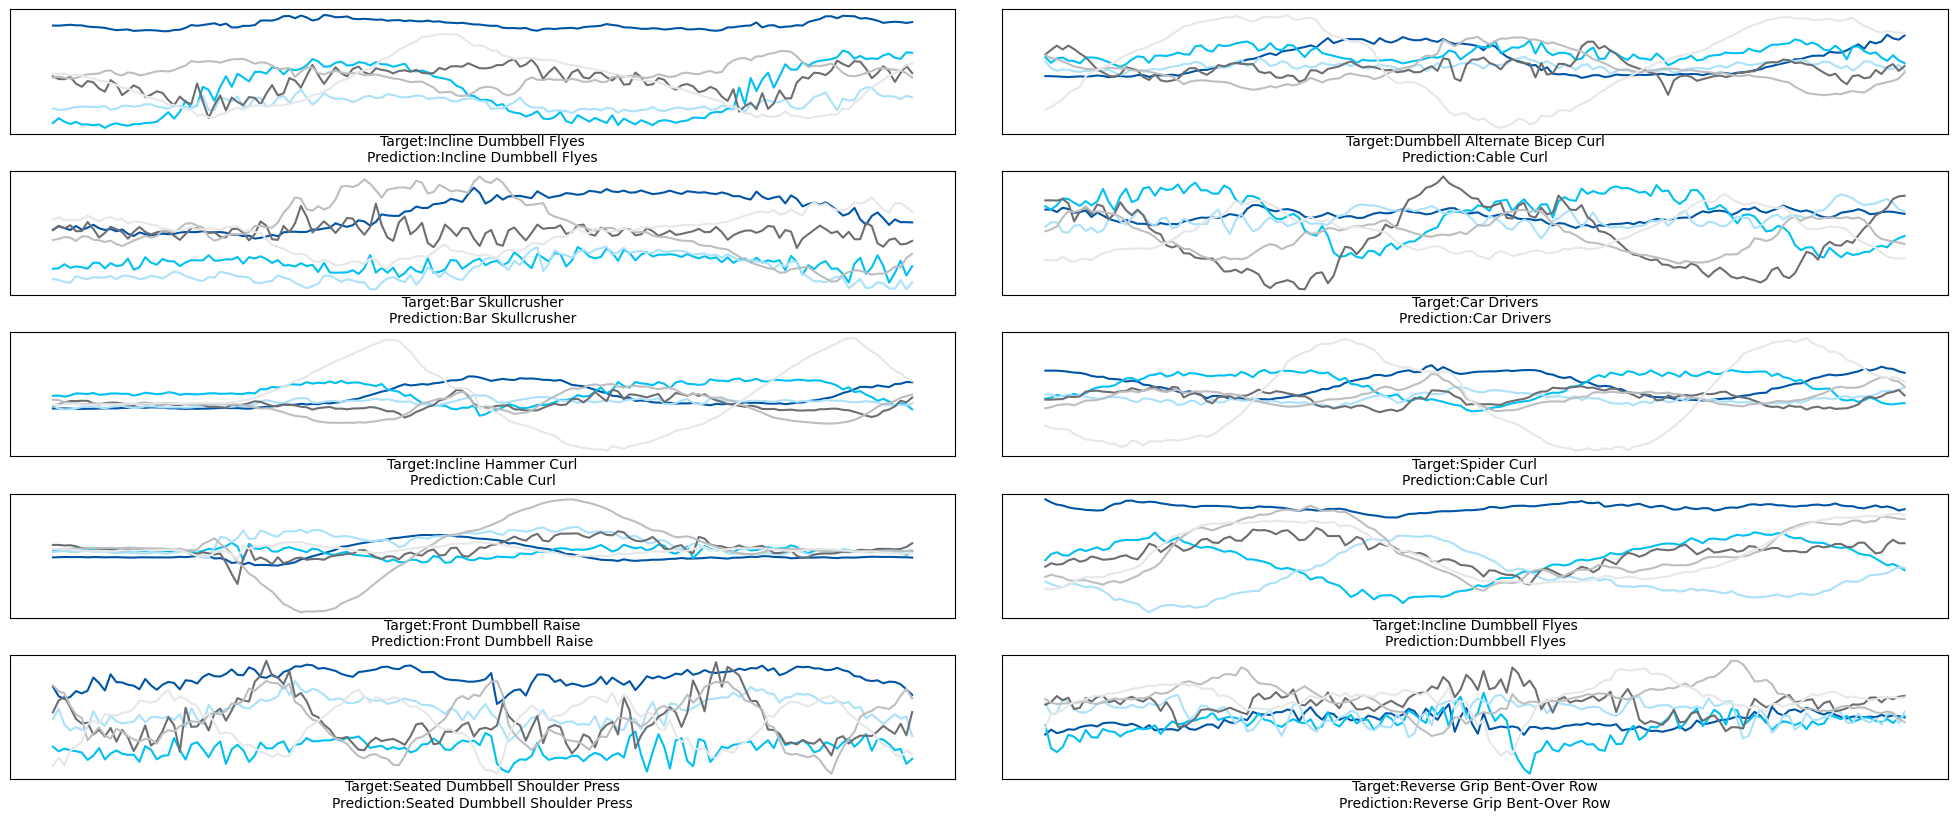

In [73]:
plot_samples(data = x_test, labels = y_test, predictions = predictions_combined_test4.numpy())

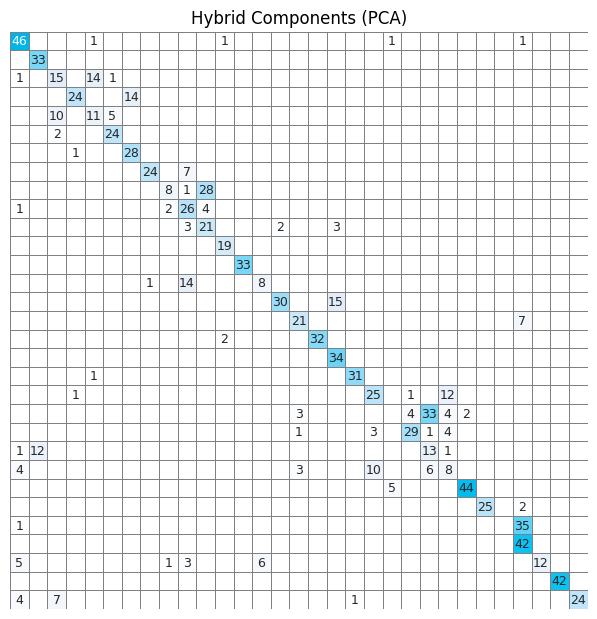

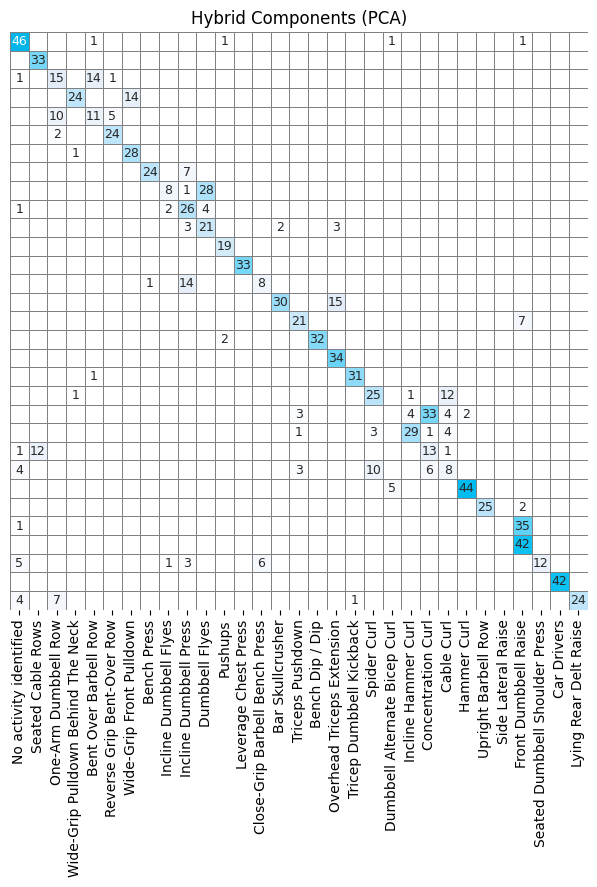

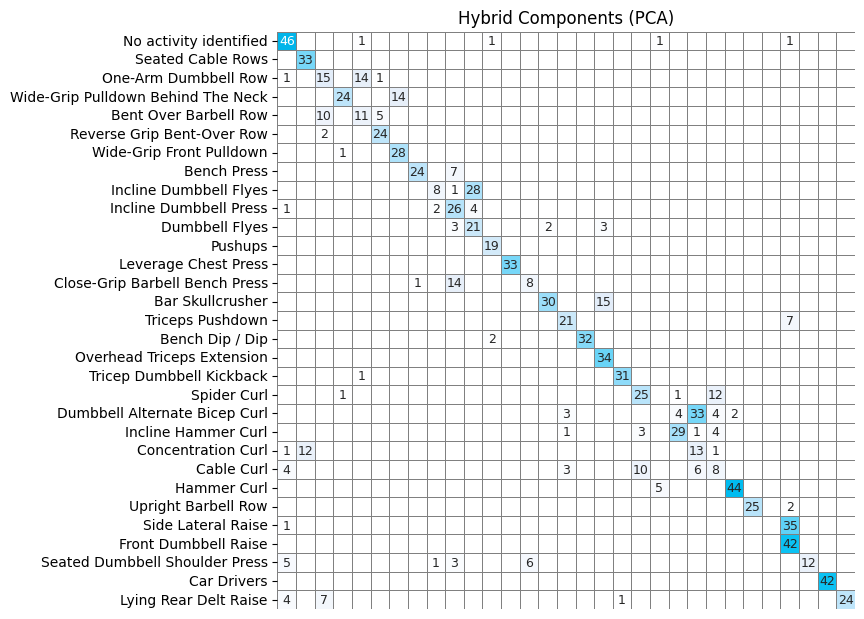

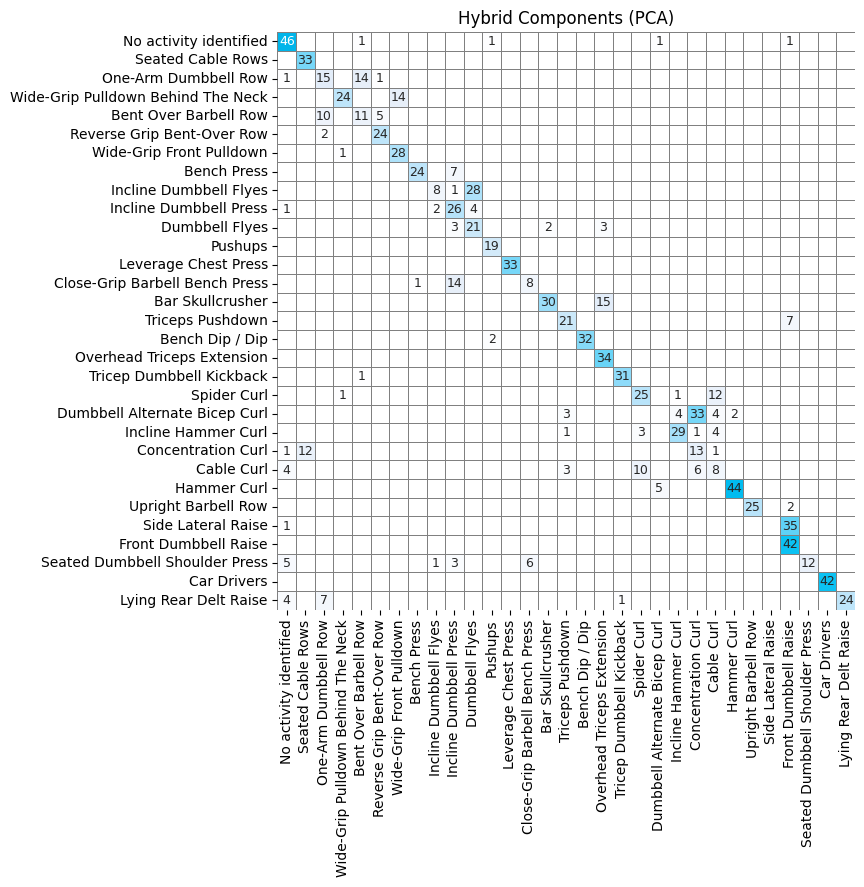

In [74]:
cm4 = confusion_matrix(y_test, predictions_combined_test4, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm4, x_ticks = False, y_ticks = False, save = True, title = "Hybrid Components (PCA)")
plot_confusion_matrix(cm4, x_ticks = True, y_ticks = False, save = True, title = "Hybrid Components (PCA)")
plot_confusion_matrix(cm4, x_ticks = False, y_ticks = True, save = True, title = "Hybrid Components (PCA)")
plot_confusion_matrix(cm4, x_ticks = True, y_ticks = True, save = True, title = "Hybrid Components (PCA)")

## **Method 5: 3 component training process (Rocket)**

In [77]:
ts_raw_input = Input(shape=(sz - 1, dim), name = "raw")
rocket_raw_input = Input(shape=(9996,), name = "rocket")

# Define the layers of the time series model
ts_layer = ConvBlock(num_filters = 32, name = "ts_ConvBlock1")(ts_raw_input)
ts_layer = ConvBlock(num_filters = 32, name = "ts_ConvBlock2")(ts_layer)
ts_layer = ResBiGRU(h1_units = 32, h2_units = 32, name = "ts_ResBiGRU1")(ts_layer)
ts_layer = GlobalMaxPooling1D(name = "ts_GlobalMaxPooling")(ts_layer)
ts_layer = BatchNormalization(momentum=0.99, center=True, scale=True, name = "ts_BatchNorm")(ts_layer)
output_ts = ts_layer

# Define the layers of the PCA model based on the Rocket features
rocket_layer = BatchNormalization(name = "rocket_BatchNorm")(rocket_raw_input)
rocket_layer = Dense(64, activation="sigmoid", name = "rocket_Dense")(rocket_layer)
output_rocket = rocket_layer

# Define the two component models
ts_model = Model(inputs=ts_raw_input, outputs=output_ts)
rocket_model = Model(inputs=rocket_raw_input, outputs=output_rocket)

# Define the layers of the combined model
combined_layer = Concatenate(axis = 1)([ts_model.output, rocket_model.output])
combined_layer = Dense(32, activation="sigmoid", name = "comb_Dense1")(combined_layer) # Compress the information into 32 dimensions
final_output  = Dense(C, activation="softmax", name = "comb_Dense2")(combined_layer)

# Define the combined model
RocketCNNResBiGRU5 = Model(inputs= {"raw": ts_model.input, "rocket": rocket_model.input}, outputs = final_output)
RocketCNNResBiGRU5.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ raw (InputLayer)          │ (None, 149, 6)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_ConvBlock1 (ConvBlock) │ (None, 149, 32)        │          2,080 │ raw[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_ConvBlock2 (ConvBlock) │ (None, 149, 32)        │         10,400 │ ts_ConvBlock1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_ResBiGRU1 (ResBiGRU)   │ (None, 149, 64)        │         25,408 │ ts_ConvBlock2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rocket (InputLayer)       │ (None, 9996)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_GlobalMaxPooling       │ (None, 64)             │              0 │ ts_ResBiGRU1[0][0]     │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rocket_BatchNorm          │ (None, 9996)           │         39,984 │ rocket[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ts_BatchNorm              │ (None, 64)             │            256 │ ts_GlobalMaxPooling[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rocket_Dense (Dense)      │ (None, 64)             │        639,808 │ rocket_BatchNorm[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 128)            │              0 │ ts_BatchNorm[0][0],    │
│ (Concatenate)             │                        │                │ rocket_Dense[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ comb_Dense1 (Dense)       │ (None, 32)             │          4,128 │ concatenate_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ comb_Dense2 (Dense)       │ (None, 31)             │          1,023 │ comb_Dense1[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 723,087 (2.76 MB)

 Trainable params: 702,839 (2.68 MB)

 Non-trainable params: 20,248 (79.09 KB)

In [80]:
rocket_layers = [layer.name for layer in rocket_model.layers]
ts_layers = [layer.name for layer in ts_model.layers]
combined_layers = [layer.name for layer in RocketCNNResBiGRU5.layers]

# The layers which are shared between both components of the model.
shared_layers = list(set(combined_layers) - set(rocket_layers) - set(ts_layers))

In [87]:
RocketCNNResBiGRU5_model = Model(inputs= {"raw": ts_model.input, "rocket": rocket_model.input}, outputs = RocketCNNResBiGRU5.output)
RocketCNNResBiGRU5_model.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
# Custom training loop
epochs = 25

# Keras optimisers are tied to the weights they are created with
comb_optimiser = Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08)
ts_optimiser = Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08)
rocket_optimiser = Adam(learning_rate=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    # Freeze the Rocket component and CNN-ResBiGRU component and train the combination component
    for layer in RocketCNNResBiGRU5_model.layers:  # Adjust indices based on your model's architecture
        if layer.name in shared_layers:
            layer.trainable = True
        else:
            layer.trainable = False
    # Keras optimisers are tied to the weights they are created with
    RocketCNNResBiGRU5_model.compile(optimizer= comb_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
    RocketCNNResBiGRU5_model.fit(train_rr_ds, validation_data = val_rr_ds, epochs=5, verbose=1, callbacks = [reduce_lr, earlystopping])

    # Freeze the Rocket component and combination component and train the CNN-ResBiGRU component
    for layer in RocketCNNResBiGRU5_model.layers:  # Adjust indices based on your model's architecture
        if layer.name in ts_layers:
            layer.trainable = True
        else:
            layer.trainable = False

    RocketCNNResBiGRU5_model.compile(optimizer= ts_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
    RocketCNNResBiGRU5_model.fit(train_rr_ds, validation_data = val_rr_ds, epochs=3, verbose=1, callbacks = [reduce_lr, earlystopping])

    # Freeze the CNN-ResBiGRU component and combination component and train the Rocket component
    for layer in RocketCNNResBiGRU5_model.layers:  # Adjust indices based on your model's architecture
        if layer.name in rocket_layers:
            layer.trainable = True
        else:
            layer.trainable = False

    RocketCNNResBiGRU5_model.compile(optimizer= rocket_optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
    RocketCNNResBiGRU5_model.fit(train_rr_ds, validation_data = val_rr_ds, epochs=2, verbose=1, callbacks = [reduce_lr, earlystopping])

Epoch 1/25
Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.4856 - loss: 2.0332 - val_accuracy: 0.5065 - val_loss: 1.8992 - learning_rate: 0.0010
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5535 - loss: 1.8050 - val_accuracy: 0.5158 - val_loss: 1.7121 - learning_rate: 0.0010
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6002 - loss: 1.6263 - val_accuracy: 0.5302 - val_loss: 1.5788 - learning_rate: 0.0010
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6192 - loss: 1.4823 - val_accuracy: 0.5374 - val_loss: 1.4725 - learning_rate: 0.0010
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6363 - loss: 1.3735 - val_accuracy: 0.5524 - val_loss: 1.3861 - learning_rate: 0.0010
Epoch 1/3
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 247ms/step - accuracy: 0.6037 - loss: 1.3698 - val_accuracy: 0.5761 - val_loss: 1.3676 - learning_rate: 0.0010
Epoch 2/3
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 0.6581 - loss: 1.2771 

In [89]:
RocketCNNResBiGRU_results5_val = RocketCNNResBiGRU5_model.evaluate(val_rr_ds, batch_size=128)
RocketCNNResBiGRU_results5_test = RocketCNNResBiGRU5_model.evaluate(test_rr_ds, batch_size=128)
print("Validation Loss: {}\nValidation Accuracy: {}".format(*RocketCNNResBiGRU_results5_val))
print("Test Loss: {}\nTest Accuracy: {}".format(*RocketCNNResBiGRU_results5_test))

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7486 - loss: 0.7413
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.6812 - loss: 1.1797
Validation Loss: 0.7383435368537903
Validation Accuracy: 0.7579023241996765
Test Loss: 1.1216939687728882
Test Accuracy: 0.6879162788391113


In [90]:
predictions_combined_val5 = RocketCNNResBiGRU5_model.predict((val_raw_tf, val_rocket_tf), batch_size=128)
predictions_combined_test5 = RocketCNNResBiGRU5_model.predict((test_raw_tf, test_rocket_tf), batch_size=128)

predictions_combined_val5 = tf.argmax(predictions_combined_val5, axis = 1)
predictions_combined_test5 = tf.argmax(predictions_combined_test5, axis = 1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


In [91]:
# Compare predictions against the targets
print("Validation Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_val5), sum(np.equal(predictions_combined_val5, y_val))))
print("Test Data - Total predictions made: %s. Number of correct predictions: %s" % (len(predictions_combined_test5), sum(np.equal(predictions_combined_test5, y_test))))

Validation Data - Total predictions made: 1392. Number of correct predictions: 1055
Test Data - Total predictions made: 1051. Number of correct predictions: 723


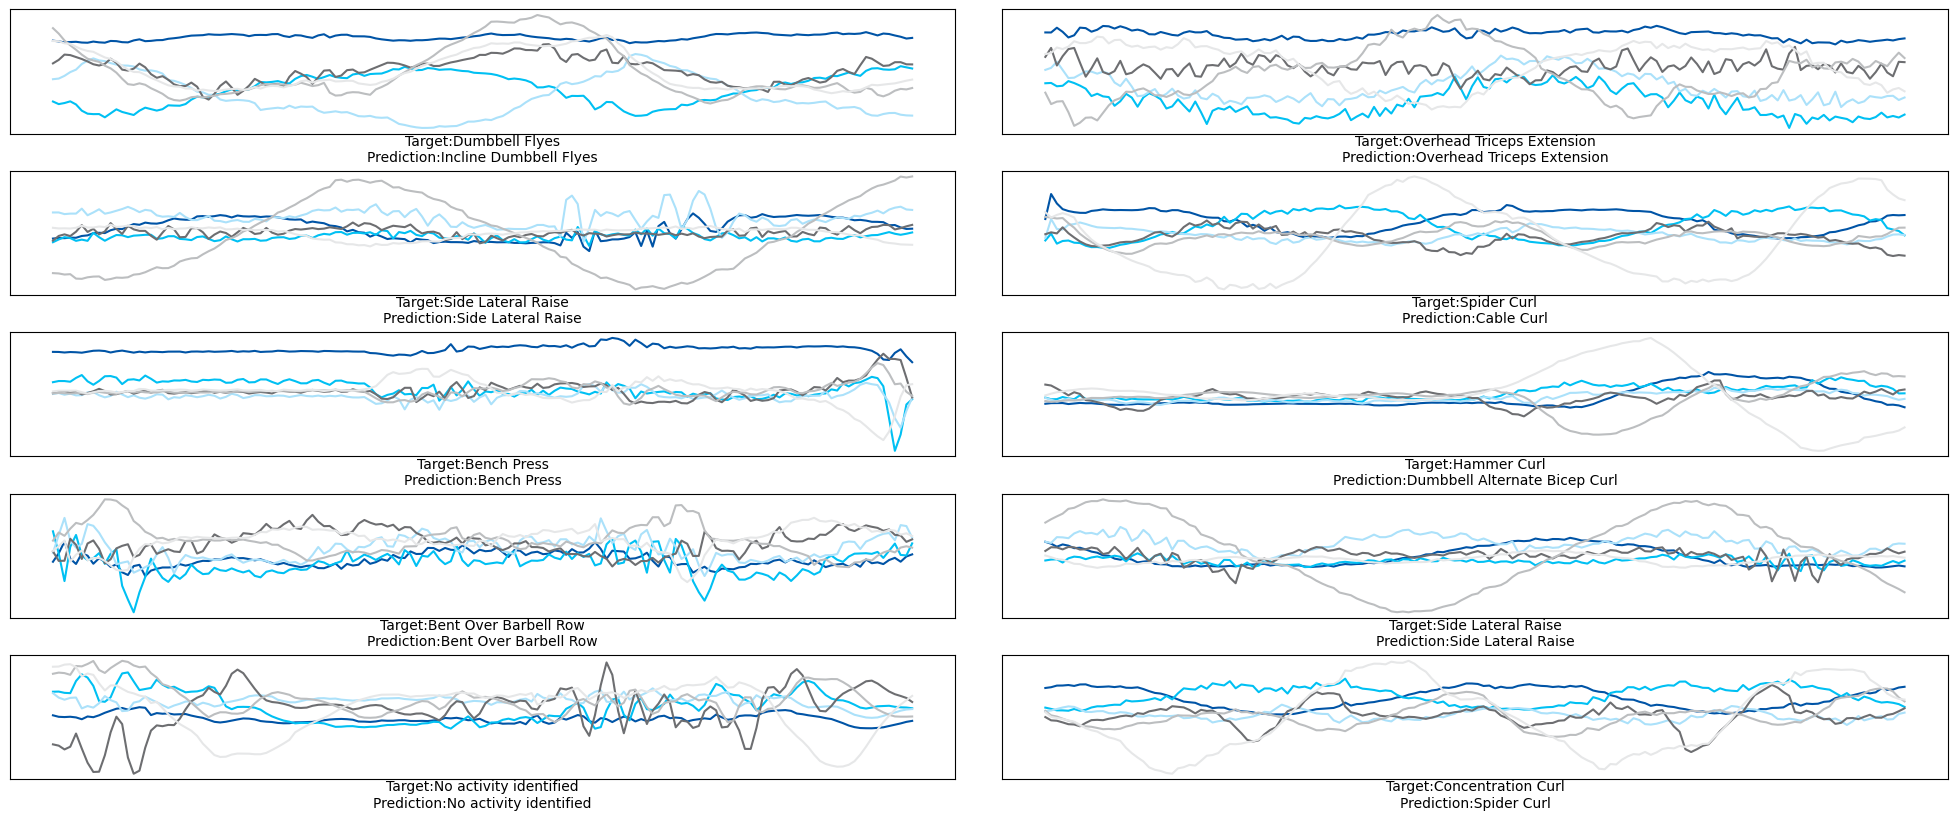

In [92]:
plot_samples(data = x_test, labels = y_test, predictions = predictions_combined_test5.numpy())

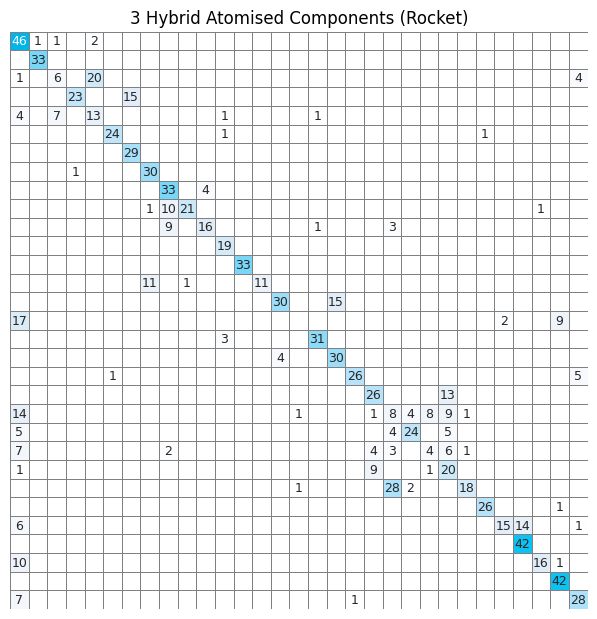

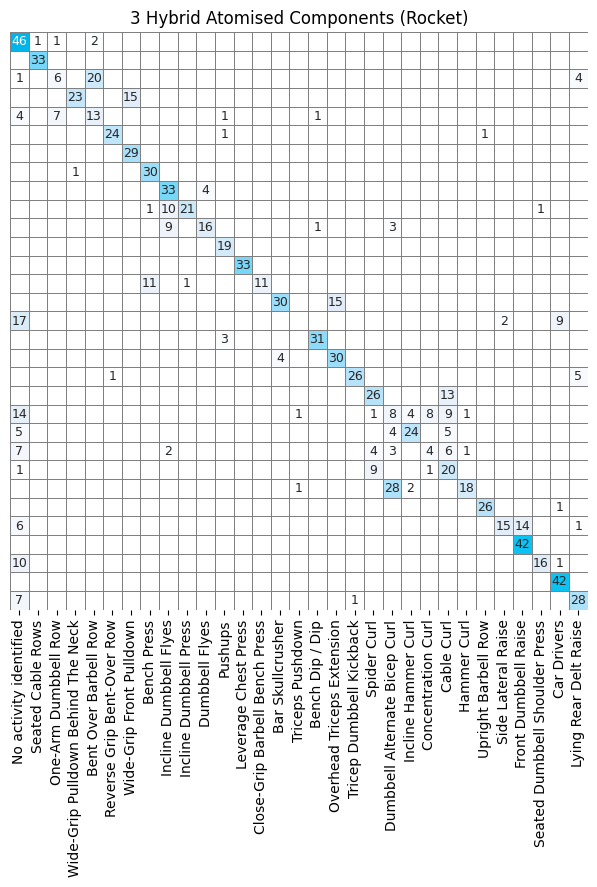

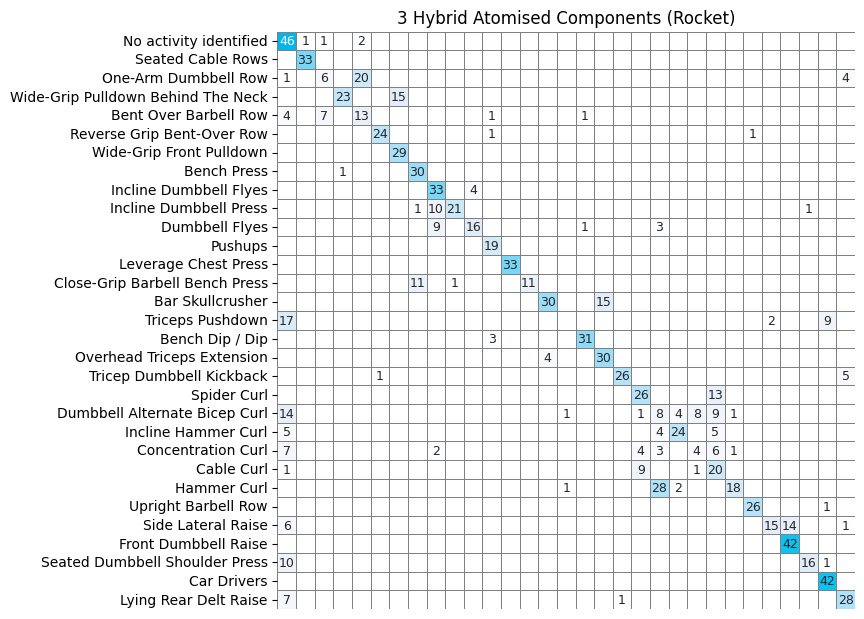

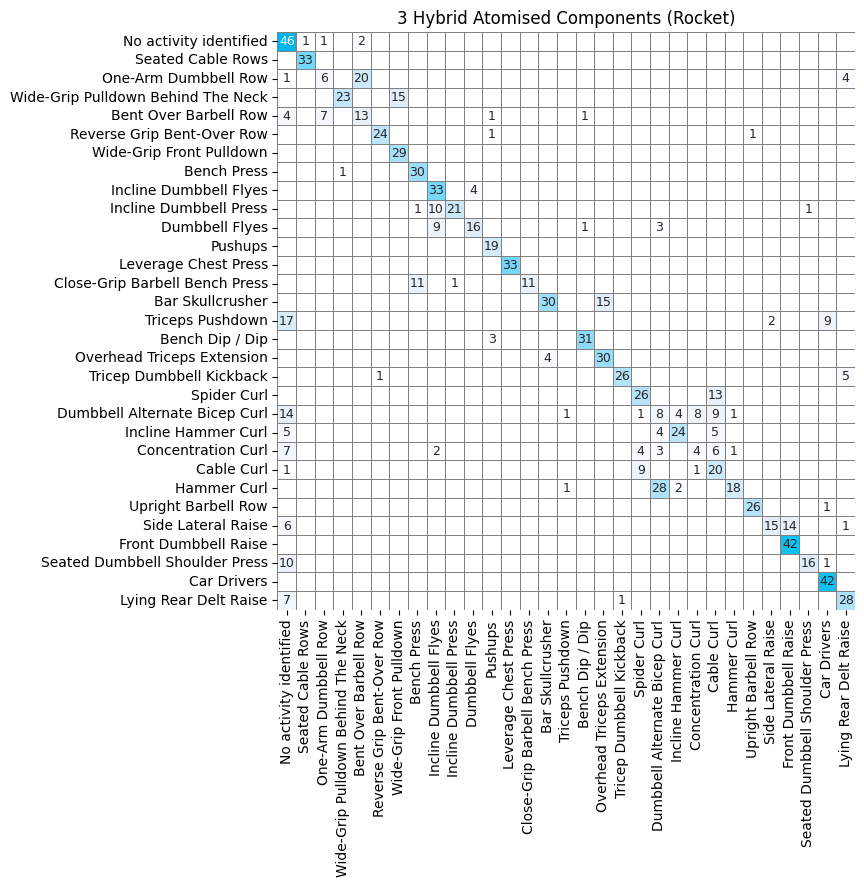

In [93]:
cm5 = confusion_matrix(y_test, predictions_combined_test5, labels = classes)

# Save 4 copies of the confusion matrix, with different permutations of x_ticks and y_ticks turned on
plot_confusion_matrix(cm5, x_ticks = False, y_ticks = False, save = True, title = "3 Hybrid Atomised Components (Rocket)")
plot_confusion_matrix(cm5, x_ticks = True, y_ticks = False, save = True, title = "3 Hybrid Atomised Components (Rocket)")
plot_confusion_matrix(cm5, x_ticks = False, y_ticks = True, save = True, title = "3 Hybrid Atomised Components (Rocket)")
plot_confusion_matrix(cm5, x_ticks = True, y_ticks = True, save = True, title = "3 Hybrid Atomised Components (Rocket)")